In this notebooks we will create a simple **hand recognition using contours** technique. <br>
Hand recognition is still quite popular problem for CV.

### Libraries import 

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt 

%matplotlib inline

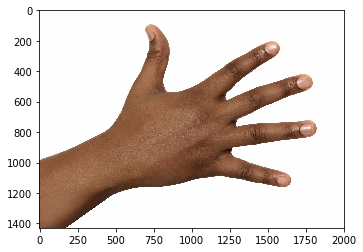

In [7]:
img = cv2.imread('images/hand.jpg')
img_copy = np.copy(img)

img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)
plt.imshow(img_copy)

### Produce binary image for Contours displaying 

We will convert image into gray scale and **produce binary image, using threshold.**<br>
We wil set up a threshold to **isolate white pixels and convert them into black**, using `cv2.THRESH_BINARY_INV` to create inverted binary threshold.

**Difference between `cv2.THRESH_BINARY` and `cv2.THRESH_BINARY_INV`**:
- `cv2.THRESH_BINARY` - turns pixels within threshold into black;
- `cv2.THRESH_BINARY_INV` - turns pixels within threshold into white.

Recall: we will output 2 results - retval and binary image using functions above. 

In [23]:
gray = cv2.cvtColor(img_copy, cv2.COLOR_RGB2GRAY)
retval, binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

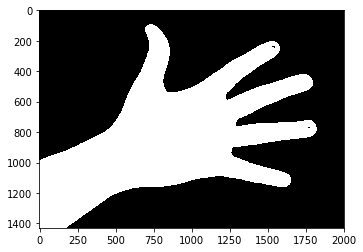

In [24]:
plt.imshow(binary, cmap = "gray")

### Finding Contours

We will use `cv2.findContours()` to find contours of an image, that has following set of params: 
- **binary image**; 
- **controur retrival mode** (we are going to have this as a tree - `cv2.RETR_TREE`);
- **contours approximation** method (we use simple chain - `cv2.CHAIN_APPROX_SIMPLE`).

Output: 
- **retval**; 
- list of **contours**;
- **hierarchy** - useful if you have many contours nested in one another. So, you can define relationships of one another. 

We are going to **plot contours on copy of an image**. 

In [85]:
contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

To draw the contours, we will use cv2 function called `cv2.drawContours()` with params: 
- copy of an **image**;
- **list of contours**; 
- **which contours to display** (**-1** means all contours);
- **color and size** of contours.

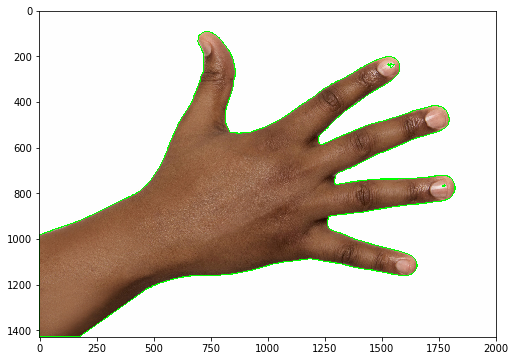

In [36]:
img_copy2 = np.copy(img_copy)
all_contours = cv2.drawContours(img_copy2, contours, -1, (0,255,0), 4)

fig = plt.figure(figsize = (16,6))

plt.imshow(all_contours)

We can see, that there is a one contour, that defines a **nice boundaty of a hand**.<br>
So, we can separate hand from the background.<br>
From this contour I can extract a lot of **information about shape of the hand**, such as :
- area;
- center;
- perimeter;
- bounding rectangle. 

The features above called **contour features**.

### Finging Contours features: orientation and bounding box

We can create a calss to automate the procedure of finding the **orientation of objects**. <br>
In case of hands we will treat **"thumb up" hand that has close to 90 degreees orientation** and "thumb down" hand with less than 90 degrees orientation.

#### Support functions

`cv2.fitEllipse()`, that takes **contour** parameter as an input from `cv2.findContours()` function and outputs: 
- (x,y), (MA, ma) - Major axis and Minor axis;
- angle - orientation in degrees.

We will write orientations of object into list to predict which one has thumb up or down.

Moreover, we will ned function, called `cv2.boundingRect()` to output 4 rectangular points (x,y, w,h) based on input parameter - **contour**. <br>
`cv2.rectangle()` is also useful to draw a rectangular based on points from function above.

Our `BounddingRectangle()` will consist of following functionality: <br>

 1) image conversion to grayscale and binary image; <br>
 2) contours finding; <br>
 3) angles estimation based on found contours; <br>
 4) object cropping. 

In [190]:
class BounddingRectangle():
    # this function will convert image into 3 color scales: rgb, gray and binary with threshold 
    #def __init__(self):
        #self.angles = []
    def convert_bin(self, image, low, high):
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
        # note, you need to keep retval as an argument (replace this by _)
        _, binary = cv2.threshold(gray, low, high, cv2.THRESH_BINARY_INV)
        return rgb, gray, binary
    
    # find the contours of an image
    def find_contour(self, binary):
        contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        return contours, hierarchy 
    
    # retrieve orientation for each contours 
    def orientation(self, contours):
        self.angles = []
        for contour in contours:
            (x,y), (ma, MA), angle = cv2.fitEllipse(contour)
            self.angles.append(angle)
        max_angle = max(self.angles)
        index = self.angles.index(max_angle)
        return index, max_angle
    
    # finally, crop specific object based on its contour using rectangle 
    def draw_rectangle(self, selected_contour, image):
        if (selected_contour is not None):
            x,y,w,h = cv2.boundingRect(selected_contour)
            bounding_box = cv2.rectangle(image, (x,y), (x+w, y+h),(200,0,200),2)
            # then, let's make a copy of an image 
            cropped_image = np.copy(image)
            cropped_image = cropped_image[y: y + h, x: x + w] 
            
            # printing part
            f = plt.figure(figsize = (16,6))
            plt.imshow(cropped_image)
            plt.title('Cropped image')

Apply this class to repeate the procedure of "thumb up" cropping. 

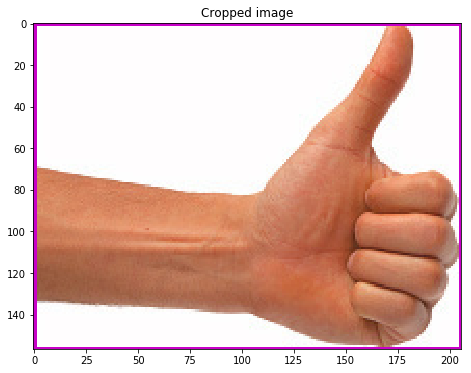

In [191]:
s1 = BounddingRectangle()

img = cv2.imread('images/thumbs_up_down.jpg')
# first we convert an image into binary
bin_img = s1.convert_bin(img, 240, 255)[2]
# then, we find contours on image 
contours = s1.find_contour(bin_img)[0]
# check which contour has an angle close to 90 degrees 
index = s1.orientation(contours)[0]
# select the contour with that index from contours list 
selected_contour = contours[index]
# select rgb image 
rgb_img = s1.convert_bin(img, 240, 255)[0]
# crop the rectangle with thmb up 
s1.draw_rectangle(selected_contour, rgb_img)